[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
[24.14692784364234, 17.287708006800656, 13.196029420970856, 10.58405560153161, 8.805104984398085, 7.527149764976026, 6.569143153821266, 5.826129932669556, 5.233841038297728, 4.751015206507982]
[582.0353551805512, 331.8458457459396, 211.59265734035762, 148.59467239582568, 111.98592135775937, 88.78677008897219, 73.05492223157398, 61.80870952832937, 53.42753584449795, 46.96983500524412]
Expected value of first hitting times:  9.392801999999993
Variance of first hitting times:  125.06225909175099
Variance of first hitting times: 125.06225909175059
p_1 = 0.6, Empirical Expectation = 25.3012
p_1 = 0.6, Empirical Variance = 615.7931
p_1 = 0.7, Empirical Expectation = 18.3059
p_1 = 0.7, Empirical Variance = 351.4057
p_1 = 0.8, Empirical Expectation = 13.9917
p_1 = 0.8, Empirical Variance = 231.1223
p_1 = 0.9, Empirical Expectation = 11.1589
p_1 = 0.9, Empirical Variance = 164.1327
p_1 = 1.0, Empirical Expectation = 9.3416
p_1 = 1.0, Empirical Variance 

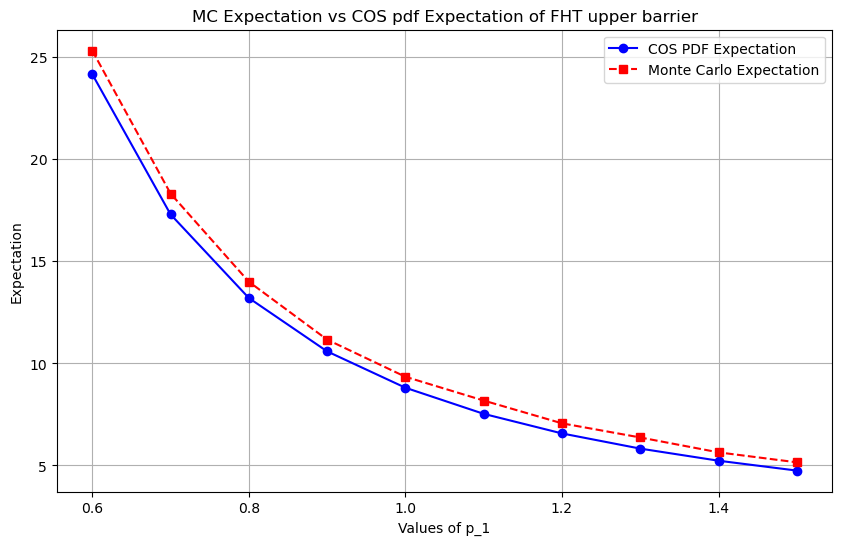

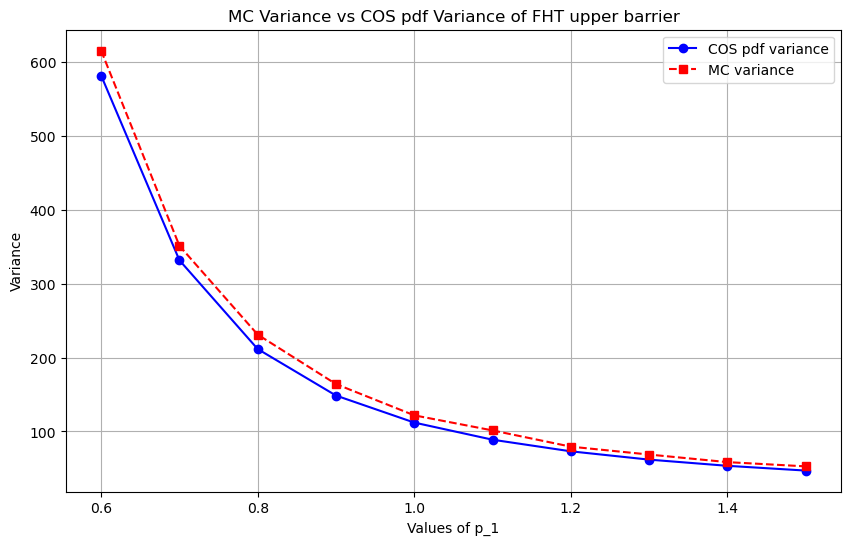

In [63]:
# testing positive values of p_1 for expectation and variance for upper barrier



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(a, degree, current_p1)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(a, degree, current_p1) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_1_values = np.arange(0.6, 1.6, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_1_values, expectation, variance

p_1_values, COS_expectation, COS_variance =expectation_variance()
print(p_1_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] >= a:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {a}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_1_values = np.arange(0.6, 1.6, 0.1)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p1 in p_1_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p1, p_2, p_3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_1 = {p1:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_1 = {p1:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_expectation, 'b-o', label='COS PDF Expectation')
plt.plot(p_1_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_1")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_variance, 'b-o', label='COS pdf variance')
plt.plot(p_1_values, MC_variance, 'r--s', label='MC variance')
plt.xlabel("Values of p_1")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
[11.678591644854226, 9.975461129616772, 8.649915250478223, 7.600119897863455, 6.7549925563453055, 6.0642650681910295, 5.491878213055989, 5.011579901372595, 4.603971879303546, 4.254510046777138]
[173.6521661541103, 135.49917871605868, 109.03180685748772, 90.04279863380717, 75.99744577251442, 65.32354490942419, 57.01603859810045, 50.41352576510555, 45.06881498882575, 40.67191395017886]
Expected value of first hitting times:  0.0
Variance of first hitting times:  0.0
Variance of first hitting times: 0.0
p_1 = 0.6, Empirical Expectation = 12.3309
p_1 = 0.6, Empirical Variance = 183.1906
p_1 = 0.7, Empirical Expectation = 10.6628
p_1 = 0.7, Empirical Variance = 151.9428
p_1 = 0.8, Empirical Expectation = 9.1447
p_1 = 0.8, Empirical Variance = 119.0638
p_1 = 0.9, Empirical Expectation = 8.0411
p_1 = 0.9, Empirical Variance = 97.4814
p_1 = 1.0, Empirical Expectation = 7.2253
p_1 = 1.0, Empirical Variance = 86.4223
p_1 = 1.1, Empirical Expectation = 6.

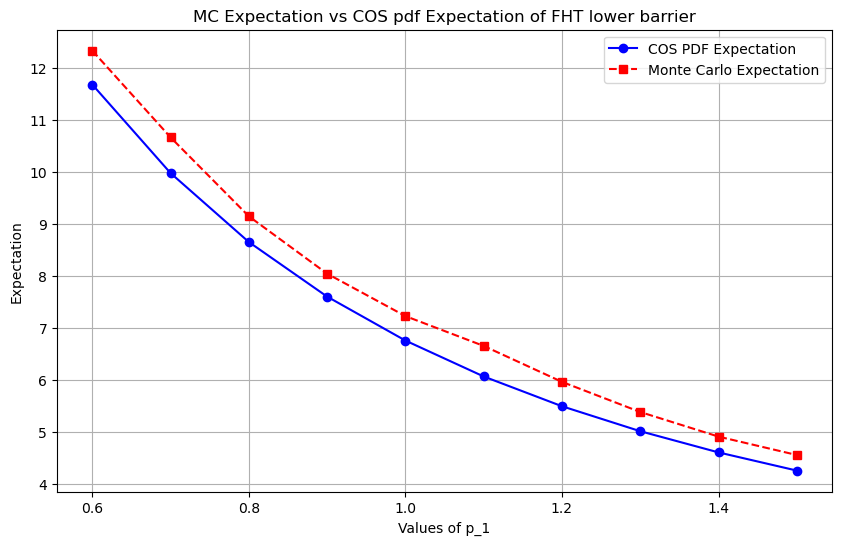

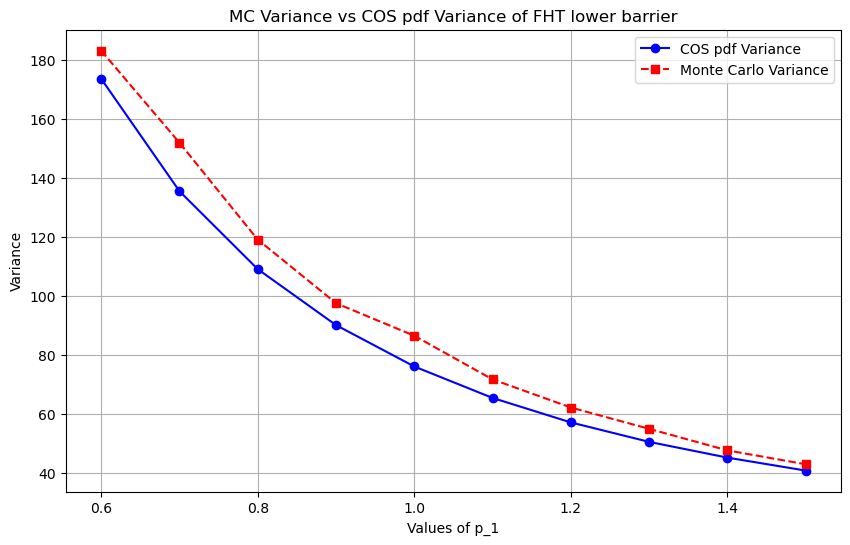

In [64]:
# testing positive values of p_1 for expectation and variance for lower barrier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 1
degree = 3

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
# s_0 = p_0 + p_1*x_0 + p_2*x_0**2 + p_3*x_0**3

b = 1.8
"""
a = 2*x_0 - inv_poly(b,3,current_p1)
mu = 2*x_0 - mu
"""
##############################


def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(b,3,current_p1))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(b, degree, current_p1)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_1_values = np.arange(0.6, 1.6, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_1_values, expectation, variance

p_1_values, COS_expectation, COS_variance =expectation_variance()
print(p_1_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] <= b:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {b}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_1_values = np.arange(0.6, 1.6, 0.1)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p1 in p_1_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p1, p_2, p_3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, b, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_1 = {p1:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_1 = {p1:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_expectation, 'b-o', label='COS PDF Expectation')
plt.plot(p_1_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_1")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_variance, 'b-o', label='COS pdf Variance')
plt.plot(p_1_values, MC_variance, 'r--s', label='Monte Carlo Variance')
plt.xlabel("Values of p_1")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6]
[4.254510046777139, 4.603971879303546, 5.011579901372595, 5.491878213055989, 6.0642650681910295, 6.7549925563453055, 7.600119897863455, 8.649915250478223, 9.975461129616772, 11.678591644854228]
[40.67191395017889, 45.06881498882575, 50.41352576510555, 57.01603859810045, 65.32354490942419, 75.99744577251442, 90.04279863380717, 109.03180685748772, 135.49917871605868, 173.65216615411032]
Expected value of first hitting times:  7.254140500000035
Variance of first hitting times:  85.53906365444281
Variance of first hitting times: 85.53906365444246
p_1 = -1.5, Empirical Expectation = 4.6790
p_1 = -1.5, Empirical Variance = 44.5165
p_1 = -1.4, Empirical Expectation = 4.9817
p_1 = -1.4, Empirical Variance = 49.5631
p_1 = -1.3, Empirical Expectation = 5.4218
p_1 = -1.3, Empirical Variance = 56.9766
p_1 = -1.2, Empirical Expectation = 5.9445
p_1 = -1.2, Empirical Variance = 62.8609
p_1 = -1.1, Empirical Expectation = 6.5289
p_1 = -1.1, Empirica

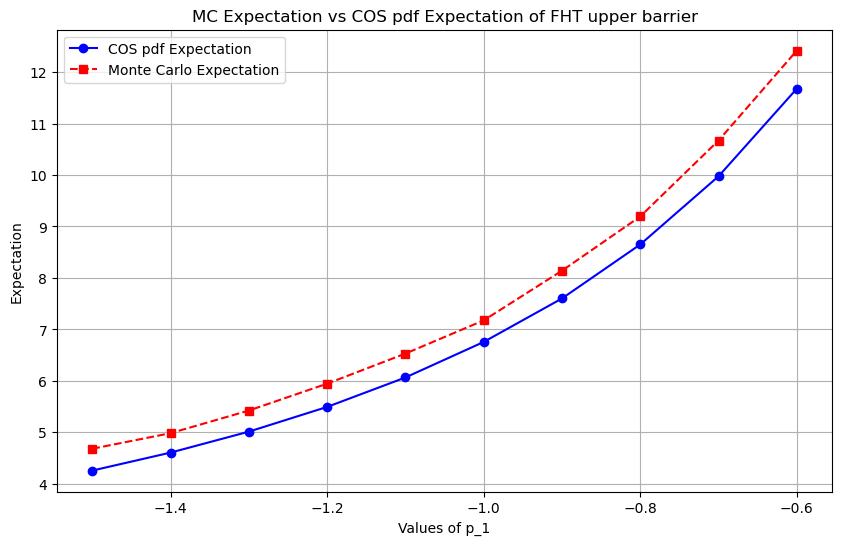

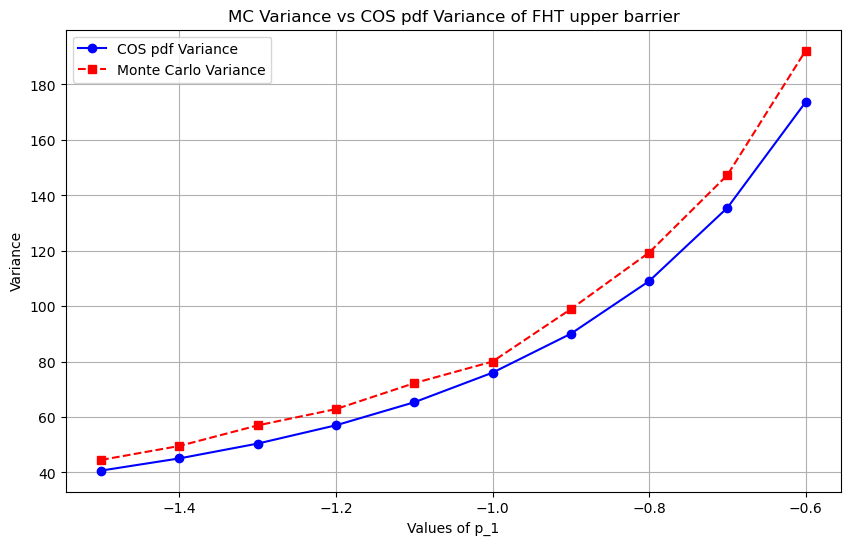

In [66]:
# testing negative values of p_1 for expectation and variance for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = -1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(a, degree, current_p1))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(a, degree, current_p1)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_1_values = np.arange(-1.5, -0.5, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_1_values, expectation, variance

p_1_values, COS_expectation, COS_variance = expectation_variance()
print(p_1_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] >= a:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)


# Reuse these values
p_1_values = np.arange(-1.5, -0.5, 0.1)  
MC_expectation = []
MC_variance = []

for p1 in p_1_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p1, p_2, p_3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_1 = {p1:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_1 = {p1:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_1_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_1")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_variance, 'b-o', label='COS pdf Variance')
plt.plot(p_1_values, MC_variance, 'r--s', label='Monte Carlo Variance')
plt.xlabel("Values of p_1")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6]
[4.751015206507982, 5.233841038297728, 5.826129932669556, 6.569143153821266, 7.527149764976026, 8.805104984398085, 10.58405560153161, 13.196029420970856, 17.287708006800656, 24.14692784364234]
[46.96983500524412, 53.42753584449795, 61.80870952832937, 73.05492223157398, 88.78677008897219, 111.98592135775937, 148.59467239582568, 211.59265734035762, 331.8458457459396, 582.0353551805512]
Expected value of first hitting times:  0.0
Variance of first hitting times:  0.0
Variance of first hitting times: 0.0
p_1 = -1.5, Empirical Expectation = 5.1813
p_1 = -1.5, Empirical Variance = 53.7343
p_1 = -1.4, Empirical Expectation = 5.6607
p_1 = -1.4, Empirical Variance = 59.6599
p_1 = -1.3, Empirical Expectation = 6.2149
p_1 = -1.3, Empirical Variance = 70.0909
p_1 = -1.2, Empirical Expectation = 6.9140
p_1 = -1.2, Empirical Variance = 80.0409
p_1 = -1.1, Empirical Expectation = 8.0472
p_1 = -1.1, Empirical Variance = 97.1052
p_1 = -1.0, Empirical 

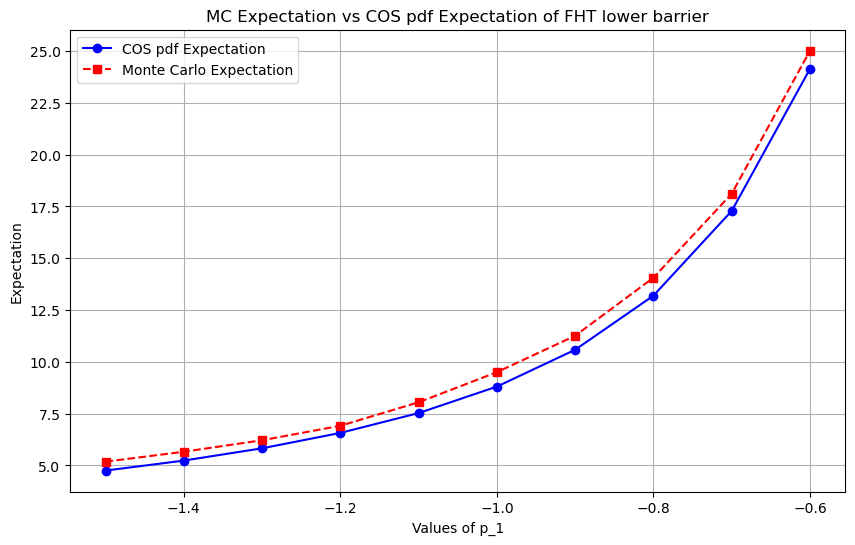

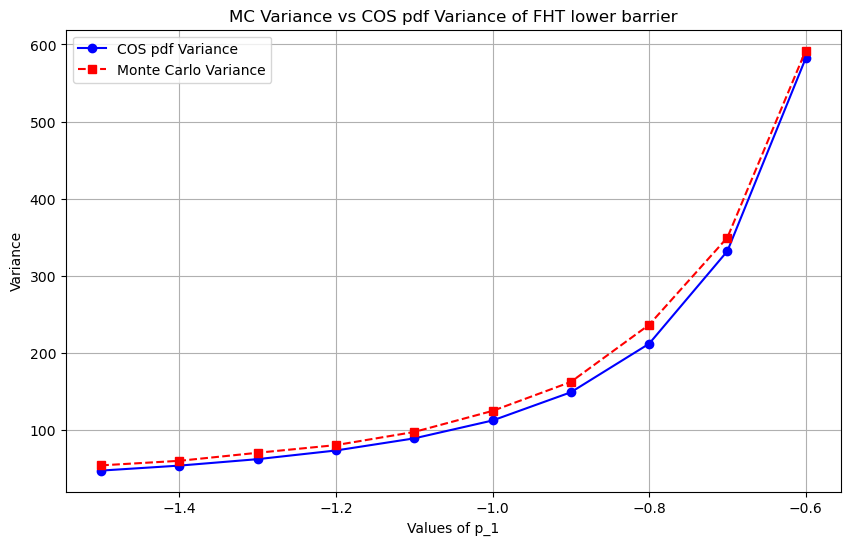

In [65]:
# testing negative values of p_1 for expectation and variance for lower barrier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = -1
degree = 3

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
# s_0 = p_0 + p_1*x_0 + p_2*x_0**2 + p_3*x_0**3

b = 1.8
"""
a = 2*x_0 - inv_poly(b,3,current_p1)
mu = 2*x_0 - mu
"""
##############################


def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(b,degree,current_p1)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(b, degree, current_p1) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def expectation_variance():
    p_1_values = np.arange(-1.5, -0.5, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    expectation = []
    variance = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        expect = np.trapz(x*f_X, x)
        expectation.append(expect)
        E_x2 = np.trapz(x**2*f_X, x)
        var = E_x2 - expect**2
        variance.append(var)
        

    return p_1_values, expectation, variance

p_1_values, COS_expectation, COS_variance =expectation_variance()
print(p_1_values)
print(COS_expectation)
print(COS_variance)
    


T = 150                                # simulation length
m = 15000                                 # number of timepoints
time_points = np.linspace(0, T, m + 1)  # time grid

def inv_poly(x,degree):
    if degree == 1:
        inv = (x- p_0) / p_1
    elif degree == 2:
        inv = 0.5 * (p_1/p_2) + np.sqrt((x/p_2) + 0.25*(p_1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*p_1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = p_1/(3*p_3)
        inv = p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))
    return inv


def simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths,p_0, p_1, p_2, p_3):
    dt = T / m

    #initialize paths
    OU_paths = np.zeros((n_paths, m + 1))
    POLY_OU_paths = np.zeros((n_paths, m + 1))
    OU_paths[:,0] = x_0
    POLY_OU_paths[:, 0] =  p_0 + p_1 * x_0 + p_2 * x_0**2 + p_3 * x_0**3

    # Generate all random shocks upfront (size: n_paths × m)
    dW = np.sqrt(dt) * np.random.normal(0, 1, size=(n_paths, m))
    
    for j in range(m):
        OU_next = OU_paths[:, j] + theta * (mu - OU_paths[:, j]) * dt + sigma * dW[:, j]
        OU_paths[:, j + 1] = OU_next
        POLY_OU_paths[:, j + 1] = p_0 + p_1 * OU_next + p_2 * OU_next**2 + p_3 * OU_next**3
    
    return POLY_OU_paths, OU_paths 


# Simulate multiple paths
n_paths = 20000


poly_ou_paths, ou_paths = simulate_POLY_OU_process(theta, mu, sigma, x_0, T, m, n_paths, p_0, p_1, p_2, p_3)

def compute_first_hitting_times(paths, b, n_paths):
    hitting_times = []
    
    for i in range(n_paths):
        hit_index = []
        for j in range (m):
            if paths[i, j] <= b:
                hit_index.append((j/m)*T)
        if len(hit_index) > 0:
            hitting_times.append(hit_index[0])  # Store first hitting time
        
    return np.array(hitting_times)

# Compute first hitting times
hitting_times = compute_first_hitting_times(poly_ou_paths, a, n_paths)

#computing average first hitting time
expected_value = sum(hitting_times)/ n_paths
print("Expected value of first hitting times: ", expected_value)

#computing variance of first hitting time
variance = sum((hitting_times - expected_value) ** 2) / (len(hitting_times) - 1)

print("Variance of first hitting times: ", variance)

variance = np.var(hitting_times, ddof=1)  # Using ddof=1 for sample variance
print("Variance of first hitting times:", variance)

"""
# Plot first 5 OU paths and their polynomial transforms
plt.figure(figsize=(14, 7))

for i in range(min(5, n_paths)):
    plt.plot(time_points, ou_paths[i], 'b-', alpha=0.6, label='OU Process' if i == 0 else "")
    plt.plot(time_points, poly_ou_paths[i], 'r--', alpha=0.6, label='Polynomial Process' if i == 0 else "")

plt.axhline(a, color='k', linestyle='--', label=f'Barrier at {a}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("OU Process vs. Polynomial Transformation (First 5 Paths)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of hitting times (if any paths hit the barrier)
if len(hitting_times) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(hitting_times, bins=120, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("First Hitting Time")
    plt.ylabel("Density")
    plt.title(f"First Hitting Times for Barrier = {b}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No paths hit the barrier; no histogram generated.")
"""
# Reuse these values
p_1_values = np.arange(-1.5, -0.5, 0.1)  # Skip 0 to avoid division errors
MC_expectation = []
MC_variance = []

for p1 in p_1_values:
    poly_ou_paths, ou_paths = simulate_POLY_OU_process(
        theta, mu, sigma, x_0, T, m, n_paths,
        p_0, p1, p_2, p_3
    )
    
    hitting_times = compute_first_hitting_times(poly_ou_paths, b, n_paths)
    
    if len(hitting_times) > 0:
        expected_value = np.mean(hitting_times)
    else:
        expected_value = np.nan  # In case no paths hit the barrier
    
    MC_expectation.append(expected_value)
    print(f"p_1 = {p1:.1f}, Empirical Expectation = {expected_value:.4f}")
    if len(hitting_times) > 0:
        variance = np.var(hitting_times, ddof=1)
    else:
        variance = np.nan  # In case no paths hit the barrier
    
    
    MC_variance.append(variance)
    print(f"p_1 = {p1:.1f}, Empirical Variance = {variance:.4f}")



plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_expectation, 'b-o', label='COS pdf Expectation')
plt.plot(p_1_values, MC_expectation, 'r--s', label='Monte Carlo Expectation')
plt.xlabel("Values of p_1")
plt.ylabel("Expectation")
plt.title("MC Expectation vs COS pdf Expectation of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_variance, 'b-o', label='COS pdf Variance')
plt.plot(p_1_values, MC_variance, 'r--s', label='Monte Carlo Variance')
plt.xlabel("Values of p_1")
plt.ylabel("Variance")
plt.title("MC Variance vs COS pdf Variance of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
[81554.9778730188, 34774.51247109769, 17390.998235750485, 10040.01285272542, 6461.1645525180265, 4502.748571648936, 3328.773274884862, 2573.385033852947, 2059.488102821269, 1693.9535121650206]
[7135192.726813226, 2500390.8817627775, 1042257.6295098627, 518269.8272604876, 296402.59168482723, 188110.7878474949, 128974.56821978764, 93738.78174840503, 71260.21753276646, 56120.20523570943]


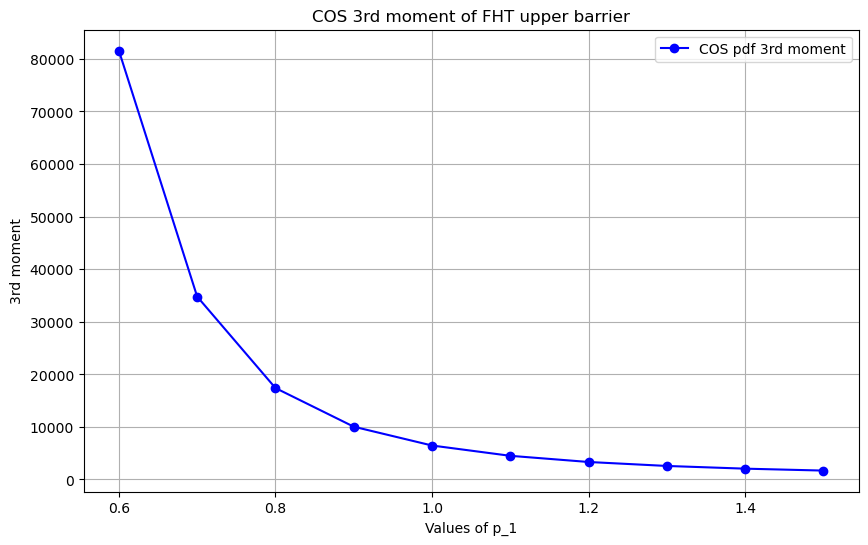

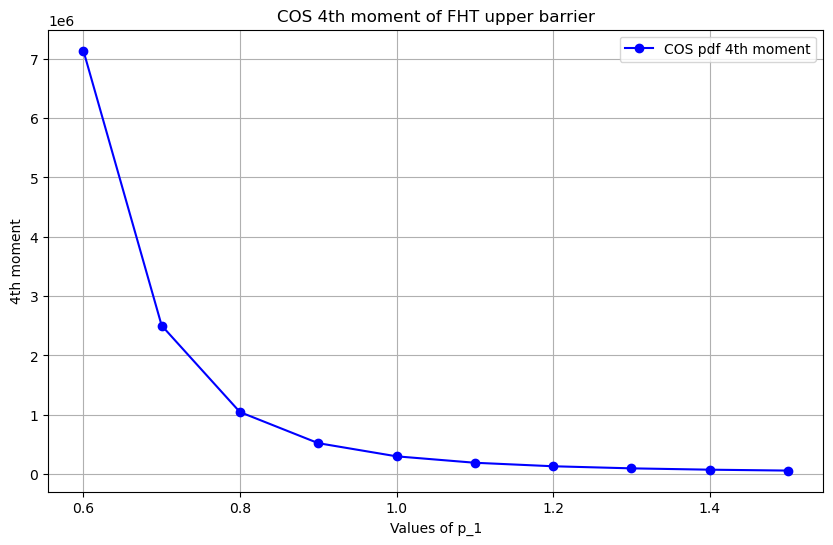

In [55]:
# testing positive values of p_1 for third, fourth moment for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(a, degree, current_p1)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(a, degree, current_p1) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_1_values = np.arange(0.6, 1.6, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_1_values, moments3, moments4

p_1_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_1_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_1")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_1")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
[12796.27896589924, 8695.6601149043, 6197.644026197103, 4602.054931106689, 3538.255425830617, 2801.5867318436703, 2274.1966068076586, 1885.4891576558466, 1591.6170179737771, 1364.4368627100732]
[705558.1698169443, 431779.7412204717, 281215.2296502684, 193329.64969468047, 139159.92971323748, 104124.18355888626, 80491.69175235141, 63959.097379169776, 52021.68241006688, 43161.86204215049]


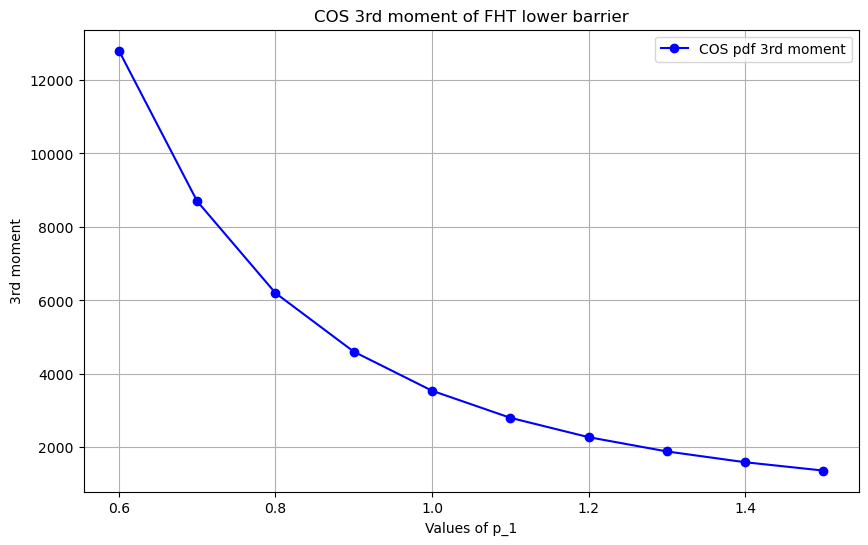

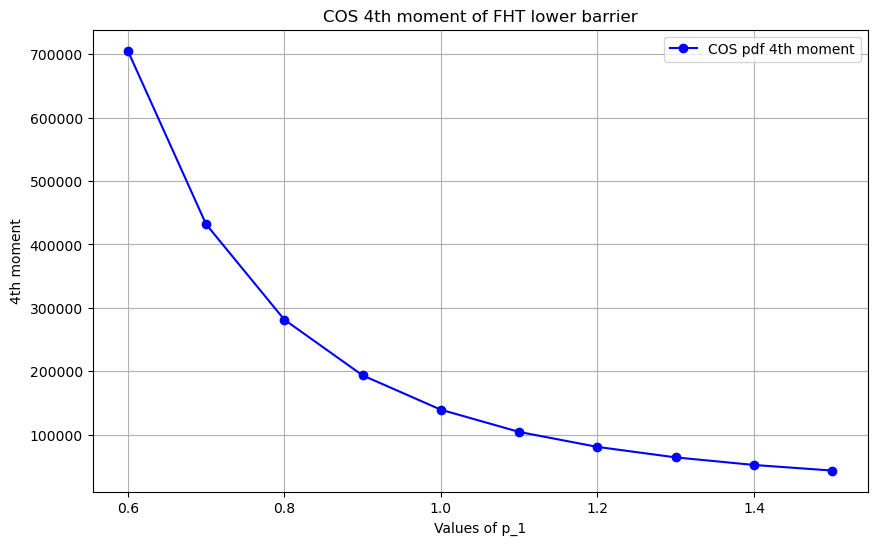

In [57]:
# testing positive values of p_1 for third, fourth moment for lower barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = 1  # Initial value, will be changed
p_2 = -0.5
p_3 = 1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
b = 1.8
"""
a = 2*x_0 - b
"""
mu = 2*x_0 - mu

##############################

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(b, degree, current_p1))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(b, degree, current_p1)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_1_values = np.arange(0.6, 1.6, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_1_values, moments3, moments4

p_1_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_1_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_1")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_1")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6]
[1364.4368627100837, 1591.6170179737771, 1885.4891576558466, 2274.1966068076586, 2801.5867318436703, 3538.255425830617, 4602.054931106689, 6197.644026197103, 8695.6601149043, 12796.278965899248]
[43161.86204215256, 52021.68241006688, 63959.097379169776, 80491.69175235141, 104124.18355888626, 139159.92971323748, 193329.64969468047, 281215.2296502684, 431779.7412204717, 705558.1698169454]


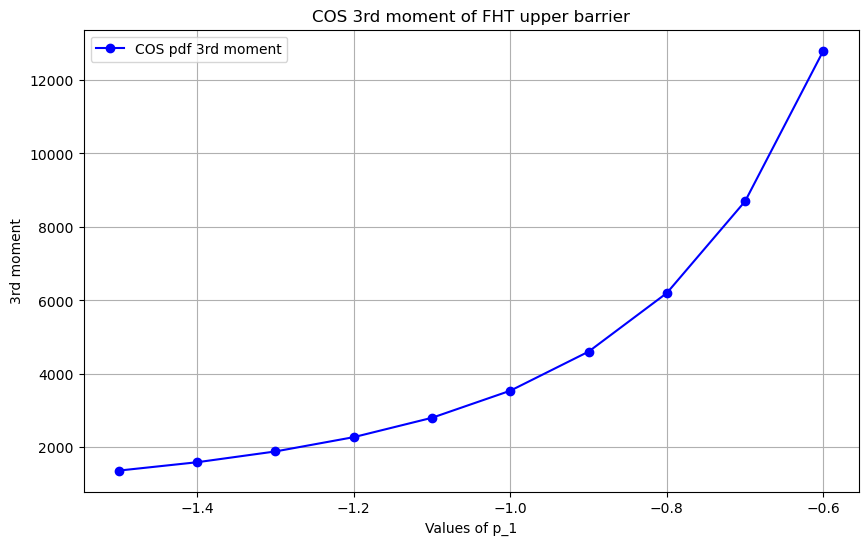

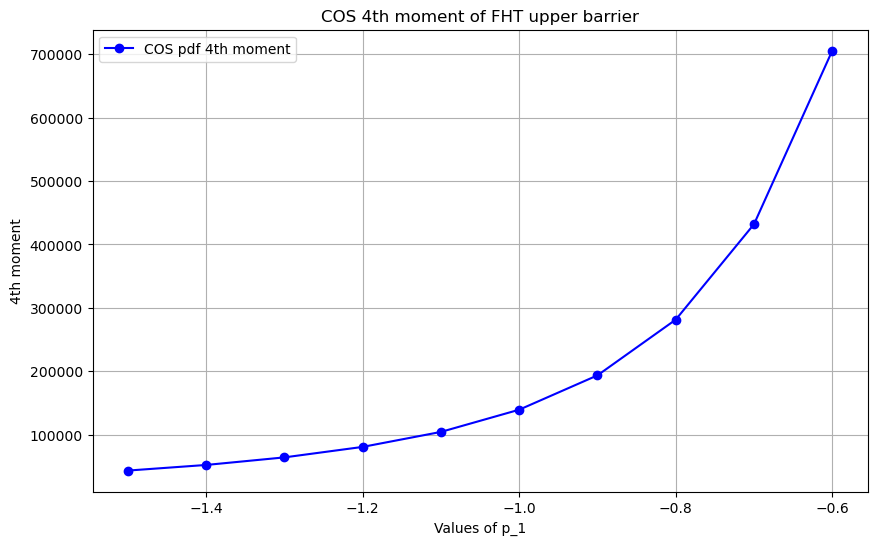

In [59]:
# testing negative values of p_1 for third, fourth moment for upper barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = -1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
"""
b = 8.
a = 2*x_0 - b
mu = 2*x_0 - mu
"""
##############################

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - (2*x_0 - inv_poly(a, degree, current_p1))) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*((2*x_0 - inv_poly(a, degree, current_p1)) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_1_values = np.arange(-1.5, -0.5, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_1_values, moments3, moments4

p_1_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_1_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_1")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_1")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT upper barrier")
plt.grid(True)
plt.legend()
plt.show()



[-1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6]
[1693.9535121650206, 2059.488102821269, 2573.385033852947, 3328.773274884862, 4502.748571648936, 6461.1645525180265, 10040.01285272542, 17390.998235750485, 34774.51247109769, 81554.9778730188]
[56120.20523570943, 71260.21753276646, 93738.78174840503, 128974.56821978764, 188110.7878474949, 296402.59168482723, 518269.8272604876, 1042257.6295098627, 2500390.8817627775, 7135192.726813226]


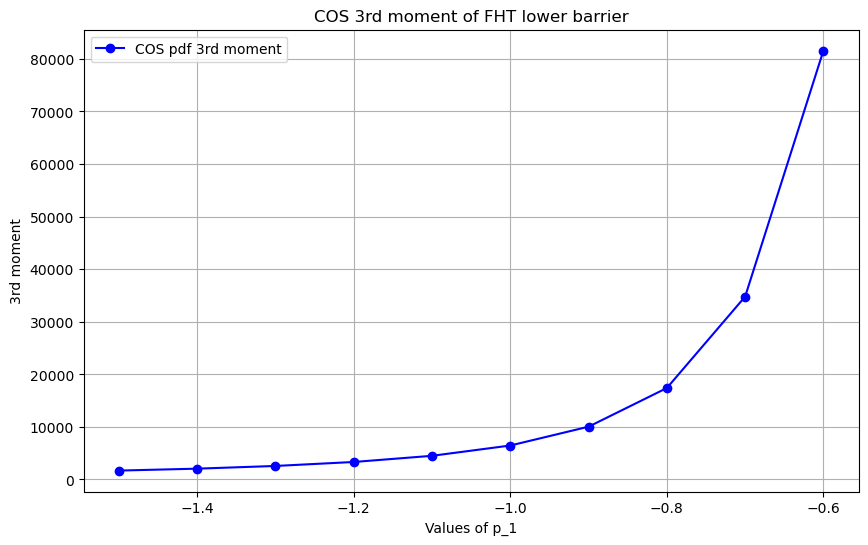

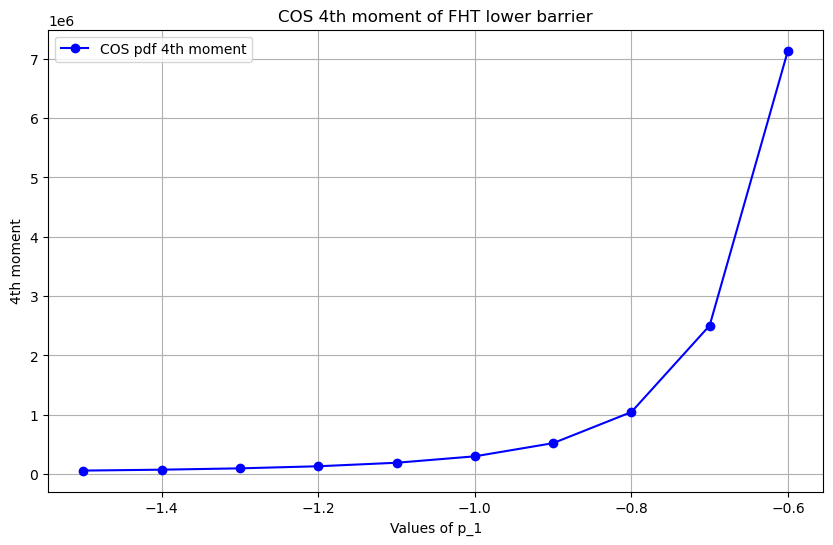

In [71]:
# testing positive values of p_1 for third, fourth moment for lower barrier


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.special import pbdv
from mpmath import mp
mp.dps = 10

# Parameters (unchanged)
theta = 0.2
mu = 0
sigma = 0.15
x_0 = 0
a = 2.2
L = 0
R = 150

# Polynomial Parameters
p_0 = 2
p_1 = -1  # Initial value, will be changed
p_2 = 0.5
p_3 = -1
degree = 3

##############################
## only use this block when you need to compute density of T_b for b<s_0
## otherwise, comment this block of code
## use change of variable, so that the Laplace transoform can be used
b = 1.8
"""
a = 2*x_0 - b
"""
mu = 2*x_0 - mu

##############################

def inv_poly(x, degree, current_p1):
    """Modified to explicitly take current_p1 as argument"""
    if degree == 1:
        return (x - p_0) / current_p1
    elif degree == 2:
        return 0.5 * (current_p1/p_2) + np.sqrt((x/p_2) + 0.25*(current_p1**2/p_2) - p_0)
    elif degree == 3:
        p = -(p_2/(3*p_3))
        q = p**3 + (p_2*current_p1 - 3*p_3*(p_0-x)) / (6*p_3**2)
        r = current_p1/(3*p_3)
        return p + np.cbrt(q + np.sqrt(q**2 + (r-p**2)**3)) + np.cbrt(q - np.sqrt(q**2 + (r-p**2)**3))

def phi(u, current_p1, x_0=x_0, mu=mu, sigma=sigma, a=a, theta=theta):
    """Modified to explicitly take current_p1 as argument"""
    y1 = ((mu - x_0) * np.sqrt(2*theta)) / sigma
    y2 = ((mu - inv_poly(b, degree, current_p1)) * np.sqrt(2*theta)) / sigma
    exp_factor = np.exp((theta*(x_0-mu)**2 - theta*(inv_poly(b, degree, current_p1) - mu)**2)/(2*sigma**2))
    v = mp.mpc(0., u/theta)
    return exp_factor * (mp.pcfd(v, y1) / mp.pcfd(v, y2))

def COSDensity(phi_func, x, N, R, L):
    """Takes phi_func as callable"""
    sum_val = 0.
    for k in range(0, N):
        F_k = 2/(R-L)*np.real(phi_func(k*np.pi/(R-L)) * np.exp(-((L*k*np.pi)/(R-L)) * 1j))
        F_k = np.real(complex(F_k))
        if k == 0:
            F_k *= 0.5
        F_k *= np.exp(np.log(10**(-16))*(k/N)**6)
        sum_val += F_k * np.cos(k * np.pi * (x - L)/(R-L))
    return sum_val

def moment3_moment4():
    p_1_values = np.arange(-1.5, -0.5, 0.1)
    p_1_values = p_1_values[p_1_values != 0]  # Remove zero to avoid division by zero
    moments3 = []
    moments4 = []
    x = np.linspace(L, R, 1000)
    n = 512
    
    for q in p_1_values:
        # Create a phi function bound to the current p_1 value
        current_phi = lambda u: phi(u, q)
        f_X = COSDensity(current_phi, x, n, R, L)
        moment3 = np.trapz(x**3*f_X, x)
        moments3.append(moment3)
        moment4 = np.trapz(x**4*f_X, x)
        moments4.append(moment4)
        

    return p_1_values, moments3, moments4

p_1_values, COS_moments3, COS_moments4 = moment3_moment4()
print(p_1_values)
print(COS_moments3)
print(COS_moments4)
    


plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments3, 'b-o', label='COS pdf 3rd moment')
plt.xlabel("Values of p_1")
plt.ylabel("3rd moment")
plt.title("COS 3rd moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(p_1_values, COS_moments4, 'b-o', label='COS pdf 4th moment')
plt.xlabel("Values of p_1")
plt.ylabel("4th moment")
plt.title("COS 4th moment of FHT lower barrier")
plt.grid(True)
plt.legend()
plt.show()

